In [18]:
from __future__ import division

import tensorflow as tf
import numpy as np
import random
import gym
from IPython import display
import matplotlib.pyplot as plt
import os
%matplotlib inline

载入Atari撞球游戏

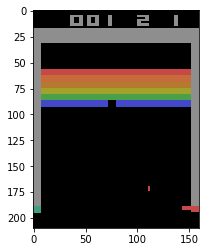

In [2]:
env = gym.make("Breakout-v0")
s = env.reset()
img = plt.imshow(env.render(mode='rgb_array'))

for i in range(200):
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    a = env.action_space.sample()
    s1, r, d, _ = env.step(a)
    if d==True:
        break

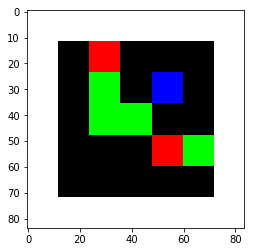

In [3]:
from gridworld import gameEnv
env = gameEnv(partial=False,size=5)

状态变量变为游戏图像，使用卷积神经网络建模，目标函数分解为对偶的状态优势和动作优势，使两者解耦，预测结果更鲁棒。

In [4]:
84*84*3

21168

In [60]:
class QNetwork:
    def __init__(self, width, height, h_size, lr=0.0001, action_num=4, channel=3):
        self.inputs = tf.placeholder(dtype=tf.float32, shape=[None, width*height*channel])
        imgs = tf.reshape(self.inputs, shape=[-1, width, height, channel])
        conv1 = tf.layers.conv2d(imgs, filters=32, kernel_size=8, strides=4, padding='VALID', bias_initializer=None)
        conv2 = tf.layers.conv2d(conv1, filters=64, kernel_size=4, strides=2, padding='VALID', bias_initializer=None)
        conv3 = tf.layers.conv2d(conv2, filters=64, kernel_size=3, strides=1, padding='VALID', bias_initializer=None)
        conv4 = tf.layers.conv2d(conv3, filters=h_size, kernel_size=7, strides=1, padding='VALID', bias_initializer=None)

        streamAC, streamVC = tf.split(conv4, 2, channel)
        streamA = tf.contrib.layers.flatten(streamAC)
        streamV = tf.contrib.layers.flatten(streamVC)
        # N,4(action_space.n)
        A = tf.layers.dense(streamA, action_num, use_bias=False)
        # N,1
        V = tf.layers.dense(streamV, 1, use_bias=False)

        # N,4
        self.Qout = V + tf.subtract(A, tf.reduce_mean(A, axis=1, keep_dims=True))
        # N,1
        self.predict = tf.argmax(self.Qout, axis=1)

        # N,1
        self.targetQ = tf.placeholder(dtype=tf.float32, shape=[None])
        # N,1
        self.actions = tf.placeholder(dtype=tf.int32, shape=[None])
        # N,4
        actions_onehot = tf.one_hot(self.actions, action_num, dtype=tf.float32)

        # N,1
        Q = tf.reduce_sum(tf.multiply(self.Qout, actions_onehot), axis=1)
        # 1
        loss = tf.reduce_mean(tf.square(Q - self.targetQ))
        optmize = tf.train.AdamOptimizer(learning_rate=lr)
        self.update = optmize.minimize(loss)

更新目标网络值

In [17]:
def updateTargetGraph(tfVars, tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx, var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) +
                                                          ((1-tau)*tfVars[idx+total_vars//2].value())))
        return op_holder

def updateTarget(op_holder, sess):
    for op in op_holder:
        sess.run(op)

训练过程，使用双向队列和随机采样实现"经验回放"，

In [62]:
from collections import deque
buff = deque(maxlen=50000)
h_size = 512
tar = 0.001

num_episode = 10000
num_exp = 50
num_pre_train = 10000
e = 1.0
batch_size = 32
discount = 0.99
update_freq = 4
path = "./dqn"
load_model = False

tf.reset_default_graph()
mainQN = QNetwork(84, 84, h_size)
targetQN = QNetwork(84, 84, h_size)
init = tf.global_variables_initializer()

saver = tf.train.saver()
trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables, tau)
if not os.path.exists(path):
    os.makedirs(path)

total_step = 0
r_list = []
with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print("Loading model...")
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    for i in range(num_episode):
        local_buff = deque(maxlen=50000)
        s = env.reset()
        s = np.reshape(s, -1)
        d = False
        r_all = 0
        for j in range(num_exp):
            if np.random.rand(1) < e or total_step<num_pre_train:
                #a = env.action_space.sample()
                a = np.random.randint(0,env.actions)
            else:
                a = sess.run(mainQN.predict, feed_dict={mainQN.inputs:[s]})[0]
            s1, r, d = env.step(a)
            s1 = np.reshape(s1, -1)
            local_buff.append(np.array([s,a,r,s1,d]))
            total_step += 1
            
            # after pre train (randomness)
            if total_step > num_pre_train:
                # reduce the random probability
                if e>0.1:
                    e -= 0.9/10000
            
                # update the Qnetwork
                if total_step % update_freq == 0:
                    batch = np.reshape(random.sample(buff, batch_size),[batch_size,5])
                    acts = sess.run(mainQN.predict, feed_dict={mainQN.inputs:np.vstack(batch[:,3])})
                    QN = sess.run(targetQN.Qout, feed_dict={targetQN.inputs:np.vstack(batch[:,3])})
                    end_token = -(batch[:,4]-1) # 游戏结束，负向惩罚
                    doubleQ = QN[range(batch_size),acts]
                    targetQ = batch[:,2] + discount*doubleQ*end_token
                    # update network with target value
                    sess.run(mainQN.update, feed_dict={mainQN.inputs:np.vstack(batch[:,0]), mainQN.targetQ:targetQ,
                                                       mainQN.actions:batch[:,1]})
                    updateTarget(targetOps, sess)
                    # udpate target network more slowly
                    #if total_step % (update_freq*1000) == 0:
                    #    sess.run(targetQN.update, feed_dict={targetQN.inputs:np.stack(batch[:,0]), 
                    #                                         targetQN.targetQ:targetQ, targetQN.actions:batch[:,1]})
            
            s = s1
            r_all += r
            
            if d==True:
                break
        buff.extend(local_buff)
        r_list.append(r_all)
        
        # save model and show the precedure
        if i % 1000 == 0:
            saver.save(sess, path+'/model-'+str(i)+'.ckpt')
            print("save model")
        if len(r_list)%10 == 0:
            print(total_step, np.mean(r_list[-10:]), e)
    saver.save(sess, path+'/model-'+str(i)+'.ckpt')

50 1.0 1.0
50050 0.0 0.0999999999999
100050 0.0 0.0999999999999


KeyboardInterrupt: 